In [21]:
%reset

In [22]:
import geopandas as gpd
import xarray as xr
import numpy as np
import regionmask
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from shapely.geometry import box, mapping
#import rioxarray as rio
#from affine import Affine
#from rasterio import features
#import importlib
import src.utilfuncs as uti
import numpy as np
from shapely.ops import unary_union

In [23]:
path_ua = '/Users/nicoleta/Desktop/data/UA_SWE/'
files_ua = path_ua + '4km_SWE_Depth*.nc'
ds_ua = xr.open_mfdataset(files_ua)

In [24]:
#def bounding_box(lower_left_longitude,
#                 lower_left_latitude,
#                 upper_right_longitude,
#                 upper_right_latitude):
#    bb_array = np.array([[lower_left_longitude, upper_right_latitude], [upper_right_longitude, upper_right_latitude], [upper_right_longitude, lower_left_latitude], [lower_left_longitude,  lower_left_latitude]])
  #  return bb_array

In [25]:
Skagit_bb_array = uti.bounding_box(-122.6, 47.8, -120, 49)

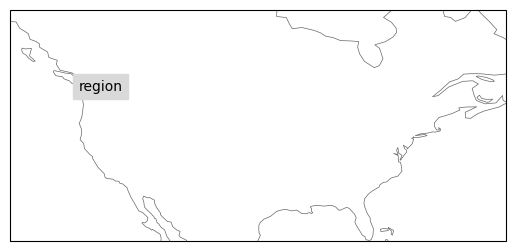

In [26]:
bb_array = Skagit_bb_array

names = ["Skagit"]
abbrevs = ["region"]

select_region = regionmask.Regions([bb_array], names=names, abbrevs=abbrevs, name="Skagit")

ax = select_region.plot(label="abbrev")

ax.set_extent([225, 300, 25, 60], crs=ccrs.PlateCarree())

#same code but for polygon example
#region_poly = Polygon(bb_array)
#regions_poly = regionmask.Regions([region_poly])
#regions_poly
#mask_poly = regions_poly.mask(ds_ua)

In [27]:


#OSSEregions_poly = regionmask.Regions([region_poly])
#OSSEregions_poly
#mask_OSSE = OSSEregions_poly.mask(ds_ua)
#mask_ = select_region.mask(ds_ua)
#sel_mask = mask_.where(mask_ == 0).values
#sel_mask
#lat = mask_.lat.values
#lon = mask_.lon.values
#id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
#id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
#out_sel1 = ds_ua.sel(lat=slice(id_lat[0], id_lat[-1]), lon=slice(id_lon[0],
                                                               #id_lon[-1])).compute().where(mask_ == 0)


In [28]:
data_sel = uti.get_selection_mask(select_region, ds_ua)

In [29]:
data_sel

<xarray.Dataset>
Dimensions:   (time: 3287, lat: 28, lon: 62, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 47.83 47.88 47.92 47.96 ... 48.83 48.88 48.92 48.96
  * lon       (lon) float32 -122.6 -122.5 -122.5 -122.5 ... -120.1 -120.1 -120.0
  * time      (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2021-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       (time, lat, lon) object b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    time_str  (time_str_len, time, lat, lon) object b'0' b'0' b'0' ... b'1' b'1'
    SWE       (time, lat, lon) float32 nan 0.0 nan nan nan ... 1.0 0.0 0.0 0.0
    DEPTH     (time, lat, lon) float32 nan 0.0 nan nan nan ... 6.0 5.0 0.0 0.0

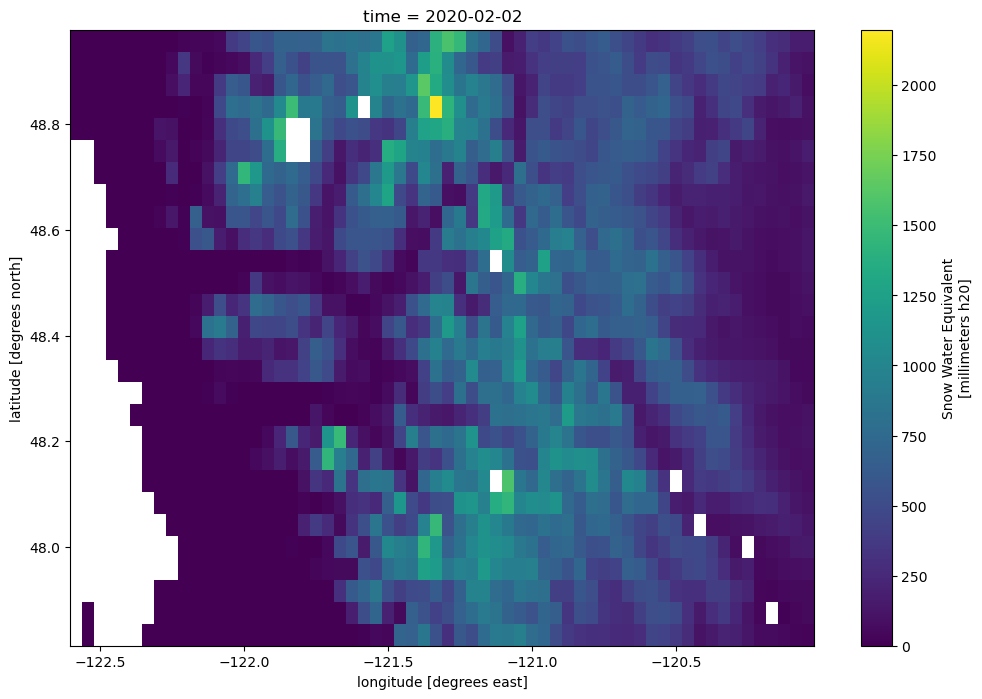

In [30]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
data_sel.SWE.sel(time='2020-02-02').plot()
#out_sel.mrro.isel(time = 1800).plot(ax = ax)


In [31]:
# use shapefile for selection
skagit_basin = gpd.read_file('/Users/nicoleta/Desktop/code/Compare_SWE/data/GIS_data/SkagitRiver_BasinBoundary.shp')
skagit_basin.head(3)

,OBJECTID,AREA,PERIMETER,SKAGIT_,SKAGIT_ID,GRID_CODE,Shape_Leng,Shape_Area,geometry
0,1,8.060220e+09,948300.0,2,1,1,948300.0,8.060220e+09,"POLYGON ((-120.81726 49.26101, -120.81520 49.2..."
1,2,2.250000e+04,600.0,3,2,1,600.0,2.250000e+04,"POLYGON ((-121.29579 48.95465, -121.29784 48.9..."


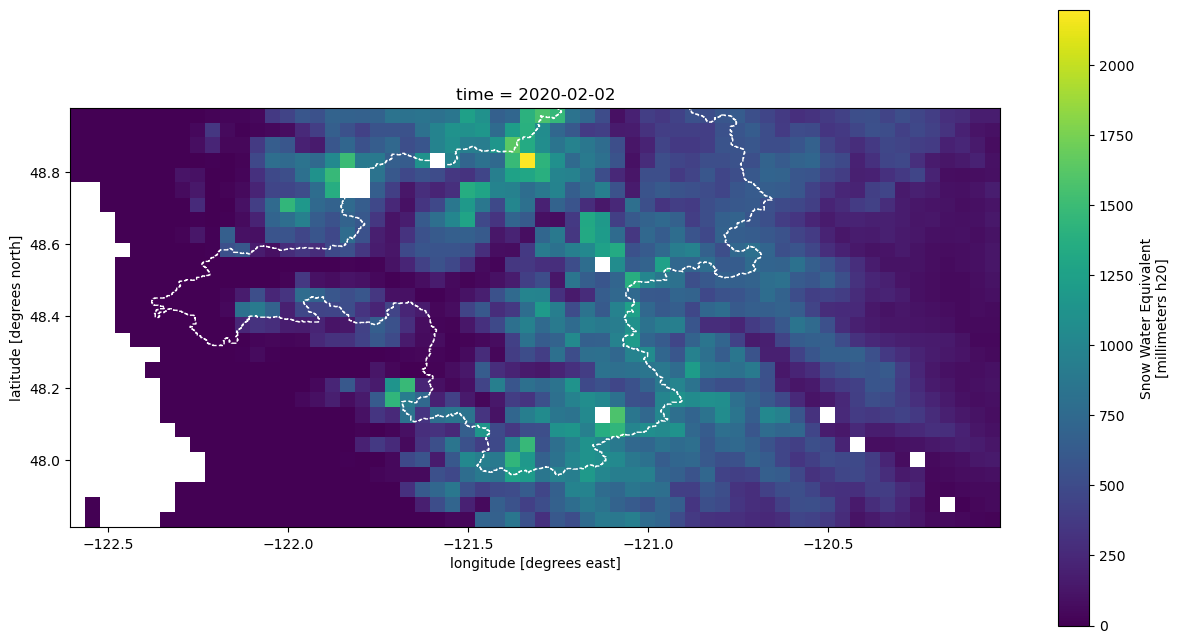

In [32]:
fig, ax = plt.subplots(figsize=(15,8))

one_day = data_sel.SWE.sel(time='2020-02-02')
one_day.plot(ax=ax)

skagit_basin.plot(ax=ax, edgecolor='white', linestyle='--', facecolor='none');

ax.set_aspect(1)

In [33]:
##one_day = one_day.to_crs(skagit_basin.crs)
##epsg:4326

##one_day = one_day.to_dataset()


#one_day_ = one_day.to_dataset()
#one_day_.rio.write_crs("epsg:4326", inplace=True)
#one_day_



In [34]:
#skagit_basin_ = skagit_basin.to_crs(one_day_.crs)

In [35]:
#skagit_one_day = one_day.rio.clip(skagit_basin.geometry.apply(mapping),crs = skagit_basin.crs)


In [36]:
#clipped = one_day.rio.clip(skagit_basin.geometry.values, skagit_basin.crs)
#geom = [shapes for shapes in skagit_basin.geometry]
#geom

In [37]:
#merge Skagit polygons
polys = [skagit_basin.iloc[0].geometry, skagit_basin.iloc[1].geometry]
mergedPolys = unary_union(polys)

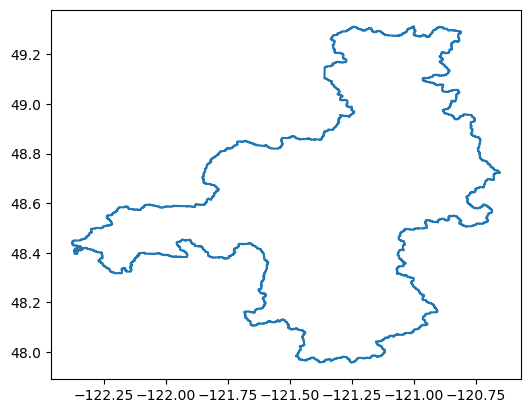

In [38]:
gpd.GeoSeries([mergedPolys]).boundary.plot()
plt.show()

In [44]:
#basin_poly = regionmask.Regions([skagit_basin.iloc[0].geometry])
basin_poly = regionmask.Regions(mergedPolys)
basin_poly
#mask_poly = regions_poly.mask(ds_ua)
#mask_poly

/opt/homebrew/Caskroom/miniforge/base/envs/compare_swe/lib/python3.9/site-packages/regionmask/core/regions.py:95: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  numbers = range(len(outlines))
/opt/homebrew/Caskroom/miniforge/base/envs/compare_swe/lib/python3.9/site-packages/regionmask/core/utils.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  values = {key: value for key, value in zip(keys, values)}


<regionmask.Regions>
Name:     unnamed
overlap:  False

Regions:
0 r0 Region0
1 r1 Region1

[2 regions]

In [35]:
#mask_poly = basin_poly.mask(ds_ua)
#sel_mask_poly = mask_poly.where(mask_ == 0).values
#sel_mask_poly
#lat = mask_poly.lat.values
#lon = mask_poly.lon.values
#id_lon = lon[np.where(~np.all(np.isnan(sel_mask_poly), axis=0))]
#id_lat = lat[np.where(~np.all(np.isnan(sel_mask_poly), axis=1))]
#out_sel1_poly = ds_ua.sel(lat=slice(id_lat[0], id_lat[-1]), lon=slice(id_lon[0],
 #                                                               id_lon[-1])).compute().where(mask_poly == 0)

In [ ]:
data_sel_basin = uti.get_selection_mask(basin_poly, ds_ua)
data_sel_basin#%%
%reset

In [ ]:
import geopandas as gpd
import xarray as xr
import numpy as np
import regionmask
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from shapely.geometry import box, mapping
#import rioxarray as rio
#from affine import Affine
#from rasterio import features
#import importlib
import src.utilfuncs as uti
import numpy as np
from shapely.ops import unary_union

In [ ]:
path_ua = '/Users/nicoleta/Desktop/data/UA_SWE/'
files_ua = path_ua + '4km_SWE_Depth*.nc'
ds_ua = xr.open_mfdataset(files_ua)

In [ ]:
#def bounding_box(lower_left_longitude,
#                 lower_left_latitude,
#                 upper_right_longitude,
#                 upper_right_latitude):
#    bb_array = np.array([[lower_left_longitude, upper_right_latitude], [upper_right_longitude, upper_right_latitude], [upper_right_longitude, lower_left_latitude], [lower_left_longitude,  lower_left_latitude]])
  #  return bb_array

In [ ]:
Skagit_bb_array = uti.bounding_box(-122.6, 47.8, -120, 49)

In [ ]:
bb_array = Skagit_bb_array

names = ["Skagit"]
abbrevs = ["region"]

select_region = regionmask.Regions([bb_array], names=names, abbrevs=abbrevs, name="Skagit")

ax = select_region.plot(label="abbrev")

ax.set_extent([225, 300, 25, 60], crs=ccrs.PlateCarree())

#same code but for polygon example
#region_poly = Polygon(bb_array)
#regions_poly = regionmask.Regions([region_poly])
#regions_poly
#mask_poly = regions_poly.mask(ds_ua)

In [ ]:


#OSSEregions_poly = regionmask.Regions([region_poly])
#OSSEregions_poly
#mask_OSSE = OSSEregions_poly.mask(ds_ua)
#mask_ = select_region.mask(ds_ua)
#sel_mask = mask_.where(mask_ == 0).values
#sel_mask
#lat = mask_.lat.values
#lon = mask_.lon.values
#id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
#id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
#out_sel1 = ds_ua.sel(lat=slice(id_lat[0], id_lat[-1]), lon=slice(id_lon[0],
                                                               #id_lon[-1])).compute().where(mask_ == 0)


In [ ]:
data_sel = uti.get_selection_mask(select_region, ds_ua)

In [ ]:
data_sel

In [ ]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
data_sel.SWE.sel(time='2020-02-02').plot()
#out_sel.mrro.isel(time = 1800).plot(ax = ax)


In [ ]:
# use shapefile for selection
skagit_basin = gpd.read_file('/Users/nicoleta/Desktop/code/Compare_SWE/data/GIS_data/SkagitRiver_BasinBoundary.shp')
skagit_basin.head(3)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

one_day = data_sel.SWE.sel(time='2020-02-02')
one_day.plot(ax=ax)

skagit_basin.plot(ax=ax, edgecolor='white', linestyle='--', facecolor='none');

ax.set_aspect(1)

In [ ]:
##one_day = one_day.to_crs(skagit_basin.crs)
##epsg:4326

##one_day = one_day.to_dataset()


#one_day_ = one_day.to_dataset()
#one_day_.rio.write_crs("epsg:4326", inplace=True)
#one_day_



In [ ]:
#skagit_basin_ = skagit_basin.to_crs(one_day_.crs)

In [ ]:
#skagit_one_day = one_day.rio.clip(skagit_basin.geometry.apply(mapping),crs = skagit_basin.crs)


In [ ]:
#clipped = one_day.rio.clip(skagit_basin.geometry.values, skagit_basin.crs)
#geom = [shapes for shapes in skagit_basin.geometry]
#geom

In [ ]:
#merge Skagit polygons
polys = [skagit_basin.iloc[0].geometry, skagit_basin.iloc[1].geometry]
mergedPolys = unary_union(polys)

In [ ]:
gpd.GeoSeries([mergedPolys]).boundary.plot()
plt.show()

In [ ]:
#basin_poly = regionmask.Regions([skagit_basin.iloc[0].geometry])
basin_poly = regionmask.Regions(mergedPolys)
basin_poly
#mask_poly = regions_poly.mask(ds_ua)
#mask_poly

In [41]:
#mask_poly = basin_poly.mask(ds_ua)
#sel_mask_poly = mask_poly.where(mask_ == 0).values
#sel_mask_poly
#lat = mask_poly.lat.values
#lon = mask_poly.lon.values
#id_lon = lon[np.where(~np.all(np.isnan(sel_mask_poly), axis=0))]
#id_lat = lat[np.where(~np.all(np.isnan(sel_mask_poly), axis=1))]
#out_sel1_poly = ds_ua.sel(lat=slice(id_lat[0], id_lat[-1]), lon=slice(id_lon[0],
    #                                                            id_lon[-1])).compute().where(mask_poly == 0)

In [42]:
data_sel_basin = uti.get_selection_mask(basin_poly, ds_ua)
data_sel_basin

<xarray.Dataset>
Dimensions:   (time: 3287, lat: 33, lon: 39, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 47.96 48.0 48.04 48.08 ... 49.17 49.21 49.25 49.29
  * lon       (lon) float32 -122.3 -122.2 -122.2 -122.2 ... -120.8 -120.8 -120.7
  * time      (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2021-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       (time, lat, lon) object nan nan nan nan nan ... b'' nan nan nan
    time_str  (time_str_len, time, lat, lon) object nan nan nan ... nan nan nan
    SWE       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    DEPTH     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

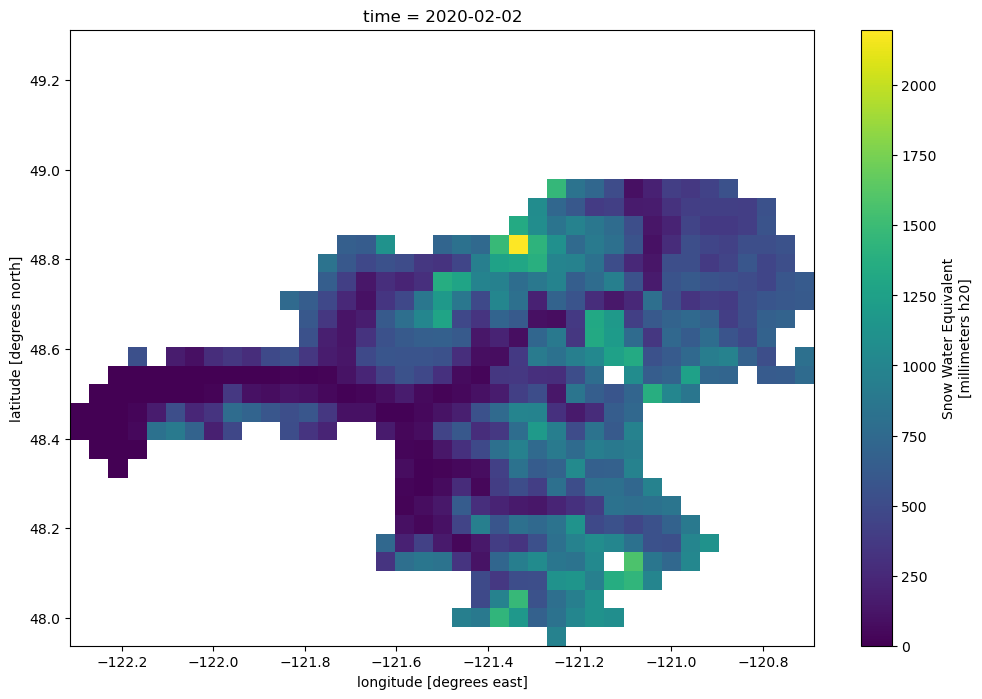

In [43]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
data_sel_basin.SWE.sel(time='2020-02-02').plot()